## Parameters to adjust

In [1]:
bias = 0.10       # Bias for the input data (1 consider all)
offset = 0.20     # Steering value to be added to the right and left cameras
zero_band = 0.20  # Consider only 10% of the zero steering data

## Load Images File

In [2]:
import csv
import numpy as np
import random

list_images = list()

with open('data\driving_log.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        steering = float(row[3])
        throttle = float(row[4])
        brake = float(row[5])
        speed = float(row[6])

        steering_thresh = np.random.rand()
        if (abs(steering) + bias) < steering_thresh:
            pass # drop sample
        else:
            if (steering == 0):
                if (np.random.rand() < zero_band):
                    # Center image
                    list_images.append([row[0].replace(" ", ""), steering, throttle, brake, speed])
                    # Left image
                    list_images.append([row[1].replace(" ", ""), steering + offset, throttle, brake, speed])
                    # Right image
                    list_images.append([row[2].replace(" ", ""), steering - offset, throttle, brake, speed])
            else:
                # Center image
                list_images.append([row[0].replace(" ", ""), steering, throttle, brake, speed])
                # Left image
                list_images.append([row[1].replace(" ", ""), steering + offset, throttle, brake, speed])
                # Right image
                list_images.append([row[2].replace(" ", ""), steering - offset, throttle, brake, speed])

print('Images mapped with {} examples'.format(len(list_images)))

Images mapped with 3030 examples


### Ploting histogram

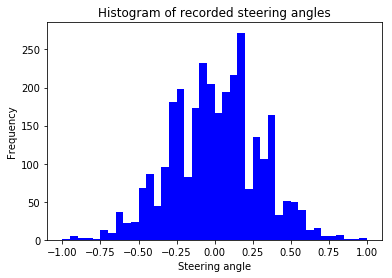

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

histogram = [x[1] for x in list_images]

plt.hist(histogram, bins = 40, facecolor='blue', range=[-1, 1], histtype='bar');
plt.xlabel('Steering angle');
plt.ylabel('Frequency');
plt.title('Histogram of recorded steering angles');

## Image Augmentation

In [4]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import random

def flip_image(img, steering):
    if random.randint(0, 1):
        return cv2.flip(img, 1), -steering
    else:
        return img, steering

def brightness_image(img, steering):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:,:,2] = hsv[:,:,2] * random.uniform(0.3, 1.2)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR), steering

def rotate_image(img, steering):
    rows,cols,channel = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), random.uniform(-5, 5), 1)
    return cv2.warpAffine(img,M,(cols,rows)), steering

def cut_image(img):
    rows,cols,channel = img.shape
    top = int(.4 * rows)
    botton = int(.85 * rows)
    border = int(.05 * cols)
    return img[top:botton, border:cols-border, :]

def translate_image(img, steering, horz_range=30, vert_range=5):
    rows, cols, chs = img.shape
    tx = np.random.randint(-horz_range, horz_range+1)
    ty = np.random.randint(-vert_range, vert_range+1)
    steering = steering + tx * 0.0025 # mul by steering angle units per pixel
    tr_M = np.float32([[1,0,tx], [0,1,ty]])
    img = cv2.warpAffine(img, tr_M, (cols,rows), borderMode=1)
    return img, steering

def shadow_image(img, steering):
    rows, cols, chs = img.shape
    
    # Generate a separate buffer
    shadows = img.copy()

    randomUp = int(random.random() * cols)
    randomDown = int(random.random() * cols)
    
    if random.randint(0, 1):
        poly = [[randomUp,0],[cols,0],[cols,rows], [randomDown,rows]]
    else:
        poly = [[randomUp,0],[0,0],[0,rows], [randomDown,0]]
        
    cv2.fillPoly(shadows, np.array([poly]), -1)

    alpha = np.random.uniform(0.6, 0.9)
    return cv2.addWeighted(shadows, alpha, img, 1-alpha,0,img), steering

## Load the data
Function to load the data given a list of images and the indices that need to be loaded. The data is only load to the memory when the generator asks.

In [5]:
def load_data_batch(list_images, indices):
    # Placeholders for the images and labels from web
    X = np.empty(shape = [1, 320, 160, 3], dtype = np.uint8)
    y = np.empty(shape = [1], dtype = np.float32)

    for i in indices:
        image = Image.open("data/" + list_images[i][0])
        steering = list_images[i][1]

        X = np.vstack([X, np.reshape(image, [1, 320, 160, 3])])
        y = np.vstack([y, steering])

    # Get rid of the first empty row
    X = X[1:, :, :, :]
    y = y[1:]

    return X, y

## Neural network implementation
Bellow will be implemented the network, which is based on [CommaAI](https://github.com/commaai/research/blob/master/train_steering_model.py) algorithm.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, Activation, MaxPooling2D, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

model_height = 64
model_weight = 64

init = 'normal'
input_shape=(model_height, model_weight, 3)

model = Sequential()

model.add(Lambda(lambda x: x/255.-0.5, input_shape=input_shape))

model.add(Convolution2D(16, 3, 3, border_mode='valid', init=init))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(32, 3, 3, border_mode='valid', init=init))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Convolution2D(48, 3, 3, border_mode='valid', init=init))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(256, init=init))
model.add(Activation('elu'))
model.add(Dropout(0.5))

model.add(Dense(128, init=init))
model.add(Activation('elu'))

model.add(Dense(16, init=init))
model.add(Activation('elu'))

model.add(Dense(1, init=init))

print(model.summary())

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 62, 62, 16)    448         lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 62, 62, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 31, 31, 16)    0           activation_1[0][0]               
___________________________________________________________________________________________

## Training and validation split

In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Shuffle list
list_images = shuffle(list_images)

# Split testing set
train_set, valid_set = train_test_split(list_images, test_size=0.2, random_state=0)

print("Train set =", len(train_set))
print("Validation set =", len(valid_set))

Train set = 2424
Validation set = 606


## Generator function
Return the images and steering values needed to the batch.

In [ ]:
def myGenerator(list, batch_size, samples_epoch, flag="test"):
    while 1:
        list = shuffle(list)

        indices = random.sample(range(len(list)), batch_size)

        X_batch = np.empty(shape = [1, model_height, model_weight, 3], dtype = np.uint8)
        y_batch = np.empty(shape = [1], dtype = np.float32)

        X, y = load_data_batch(list, indices)

        for i in range(0, batch_size):

            image = X[i]
            steering = y[i]

            if (flag == "test"):
                image, steering = brightness_image(np.copy(image), steering)
                image, steering = rotate_image(np.copy(image), steering)
                image, steering = translate_image(np.copy(image), steering)
                image, steering = shadow_image(np.copy(image), steering)
                image, steering = flip_image(np.copy(image), steering)

            image = cut_image(image)

            image = cv2.resize(image,(model_height, model_height), interpolation = cv2.INTER_CUBIC)

            X_batch = np.vstack([X_batch, np.reshape(image, [1, model_height, model_weight, 3])])
            y_batch = np.vstack([y_batch, steering])

        # Get rid of the first empty row
        X_batch = X_batch[1:, :, :, :]
        y_batch = y_batch[1:]

        yield (X_batch, y_batch)

## Neural network training

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# compile and fit model
print("Fitting model")

model.compile(loss='mse', metrics=['mse'], optimizer=Adam(lr=0.001))

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=3, verbose=1)
#model_checkpoint = ModelCheckpoint(filepath='model.weights.{epoch:02d}-{val_loss:.5f}.h5', verbose=1, save_best_only=True, save_weights_only=True)
learning_rate_plateau_reducer = ReduceLROnPlateau(verbose=1, patience=2, epsilon=1e-5)

batch_size=2**9
samples_epoch_test = 2**12
samples_epoch_validation = 2**10
n_epoch = 10

fit = model.fit_generator(myGenerator(train_set, batch_size, samples_epoch_test),
                          verbose=1, samples_per_epoch=samples_epoch_test,
                          nb_epoch=n_epoch,
                          callbacks=[learning_rate_plateau_reducer, early_stopping],
                          validation_data=myGenerator(valid_set, batch_size, samples_epoch_validation, "validation"),
                          nb_val_samples = samples_epoch_validation)

# output model
print("Saving model structure and weights")
model_json = model.to_json()
import json
with open ('model.json', 'w') as f:
    json.dump(model_json, f, indent=4, sort_keys=True, separators=(',', ':'))

model.save_weights('model.h5')

Fitting model
Epoch 1/10
4096/4096 [==============================] - 257s - loss: 0.0945 - mean_squared_error: 0.0945 - val_loss: 0.0772 - val_mean_squared_error: 0.0772
Epoch 2/10
1024/4096 [======>.......................] - ETA: 12s - loss: 0.0888 - mean_squared_error: 0.0888